In [2]:
import numpy as np
import torch
import os
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import PIL
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip '/content/drive/MyDrive/parkinsons.zip'

Archive:  /content/drive/MyDrive/parkinsons.zip
replace drawings/spiral/testing/healthy/V01HE01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: drawings/spiral/testing/healthy/V01HE01.png  
  inflating: drawings/spiral/testing/healthy/V02HE01.png  
  inflating: drawings/spiral/testing/healthy/V03HE1.png  
  inflating: drawings/spiral/testing/healthy/V04HE01.png  
  inflating: drawings/spiral/testing/healthy/V05HE01.png  
  inflating: drawings/spiral/testing/healthy/V06HE01.png  
  inflating: drawings/spiral/testing/healthy/V07HE01.png  
  inflating: drawings/spiral/testing/healthy/V08HE01.png  
  inflating: drawings/spiral/testing/healthy/V09HE01.png  
  inflating: drawings/spiral/testing/healthy/V10HE01.png  
  inflating: drawings/spiral/testing/healthy/V11HE01.png  
  inflating: drawings/spiral/testing/healthy/V55HE12.png  
  inflating: drawings/spiral/testing/healthy/V55HE13.png  
  inflating: drawings/spiral/testing/healthy/V55HE14.png  
  inflating: drawings/spiral/testi

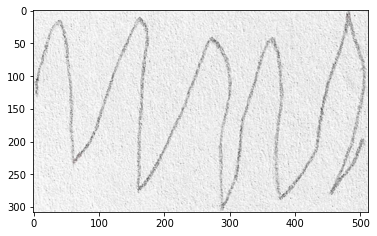

In [5]:
img = cv2.imread('/content/wave/training/parkinson/V15PO03.png')
plt.imshow(img)
plt.show()

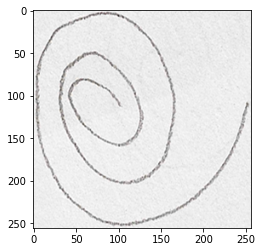

In [6]:
img = cv2.imread('/content/spiral/training/healthy/V55HE06.png')
plt.imshow(img)
plt.show()

In [ ]:
#torch based data processing
class Preprocess(nn.module):
  def __init__(self,rootpath,transforms):
    self.root = rootpath
    self.files = os.listdir(self.root)
    self.t = transforms

  def __len__(self):
    return len(self.files)
  def __getitem__(self, x):
    imcurr = self.files[x]
    print(imcurr)
    imfile = os.path.join(self.files[x], imcurr)
    img = Image.open(imfile)
    #img = np.array(img)
    img = self.t(img)
    return img

In [7]:
def HOG(image):
	features = feature.hog(image, orientations=9,pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		                      transform_sqrt=True, block_norm="L1")
	return features

In [8]:
def Dataloader(path):
  imgpaths = list(paths.list_images(path))
  imgs,labels = [],[]
  for i in imgpaths:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    img = cv2.threshold(img, 0,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    imfeat = HOG(img)

    imgs.append(imfeat)
    labels.append(i.split('/')[4])
  return np.array(imgs), np.array(labels)

In [9]:
xtrain,ytrain = Dataloader('/content/wave/training')
xtest,ytest = Dataloader('/content/wave/testing')

In [11]:
sxtrain,sytrain = Dataloader('/content/spiral/training')
sxtest, sytest = Dataloader('/content/spiral/testing')

In [12]:
print(len(xtrain))

72


In [13]:
print(len(ytrain))

72


In [14]:
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.fit_transform(ytest)

In [15]:
le = LabelEncoder()
sytrain = le.fit_transform(sytrain)
sytest = le.fit_transform(sytest)

In [ ]:
class LogisticRegression:

  def Sigmoid(self, z):
    y = 1/(1 + np.exp(-z))
    return y

  def init_wts(self, x):
    weights = np.zeros((np.shape(x)[1]+1,1))
    x = np.c_[np.ones((np.shape(x)[0],1)),x]
    return weights, x


  def fit(self, x, y, iters = 400, a=0.001):
    weights, x = self.init_wts(x)

    #cost calc
    def cost(theta):
      z = np.dot(x, theta)
      c0 = y.T * np.log(self.Sigmoid(z))
      c1 = (1-y).T * np.log(1-self.Sigmoid(z))
      fcost = -(c1+c0)/len(y)
      return fcost
    #clist = np.zeros(iters,)
    clist = []
    for i in range(iters):
      weights = weights - a*np.dot(x.T, self.Sigmoid(np.dot(x,weights))-np.reshape(y,(len(y),1)))
      clist.append(cost(weights))
    self.weights = weights
    return clist
  
  def predict(self, x):
    z = np.dot(self.init_wts(x)[1],self.weights)
    res = []
    for i in self.Sigmoid(z):
      if i > 0.5:
        res.append(1)
      else:
        res.append(0)
    return res


In [ ]:
lrs = LogisticRegression()
lrs.fit(xtrain,ytrain)

In [ ]:
res = lrs.predict(xtest)

In [ ]:
cm = confusion_matrix(ytest,res)
print(cm)

[[ 8  7]
 [ 4 11]]


In [ ]:
(tn,fp),(fn,tp) = cm

In [ ]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1_score = 2*precision*recall / (precision + recall)

print('Wave classification using Logistic Regression \nPrecision: '+ str(round(precision,4)) + '\nRecall: ' + str(round(recall,4)) + '\nF1 Score: ' + str(round(f1_score,4)))

Wave classification using Logistic Regression 
Precision: 0.6111
Recall: 0.7333
F1 Score: 0.6667


In [ ]:
accuracy = (tn+tp) / float(cm.sum())
print('Wave classification using Logistic Regression \nAccuracy value:', accuracy)

Wave classification using Logistic Regression 
Accuracy value: 0.6333333333333333


In [ ]:
spiral_lr = LogisticRegression()
spiral_lr.fit(sxtrain,sytrain)

In [ ]:
sres = spiral_lr.predict(sxtest)

In [ ]:
scm = confusion_matrix(sytest,sres)
print(scm)

[[11  4]
 [ 4 11]]


In [ ]:
(tn,fp),(fn,tp) = scm

In [ ]:
precision = tp / (fp + tp)
recall = tp / (fn + tp)
f1_score = 2*precision*recall / (precision + recall)

print('Spiral classification using Logistic Regression \nPrecision: '+ str(round(precision,4)) + '\nRecall: ' + str(round(recall,4)) + '\nF1 Score: ' + str(round(f1_score,4)))

Spiral classification using Logistic Regression 
Precision: 0.7333
Recall: 0.7333
F1 Score: 0.7333


In [ ]:
accuracy = (tn+tp) / float(scm.sum())
print('Spiral classification using Logistic Regression \nAccuracy value:', round(accuracy,1))

Spiral classification using Logistic Regression 
Accuracy value: 0.7


In [16]:
WaveMod = RandomForestClassifier()
WaveMod.fit(xtrain,ytrain)

RandomForestClassifier()

In [18]:
wres = WaveMod.predict(xtest)
wcm = confusion_matrix(ytest,wres)

In [19]:
print(wcm)

[[10  5]
 [ 2 13]]


In [21]:
(wtn,wfp),(wfn,wtp) = wcm

In [22]:
precision = wtp / (wfp + wtp)
recall = wtp / (wfn + wtp)
f1_score = 2*precision*recall / (precision + recall)

print('Wave classification using Logistic Regression \nPrecision: '+ str(round(precision,4)) + '\nRecall: ' + str(round(recall,4)) + '\nF1 Score: ' + str(round(f1_score,4)))

Wave classification using Logistic Regression 
Precision: 0.7222
Recall: 0.8667
F1 Score: 0.7879


In [20]:
(wtn,wfp),(wfn,wtp) = wcm
acc = (wtn+wtp) / float(wcm.sum())
print('Wave model - Random forest classifier accuracy value:',round(acc,2))

Wave model - Random forest classifier accuracy value: 0.77


In [23]:
SpiralMod = RandomForestClassifier()
SpiralMod.fit(sxtrain,sytrain)

RandomForestClassifier()

In [24]:
spiral_res = SpiralMod.predict(sxtest)
spiral_cm = confusion_matrix(sytest,spiral_res)

In [25]:
print(spiral_cm)

[[14  1]
 [ 7  8]]


In [26]:
(stn,sfp),(sfn,stp) = spiral_cm

In [27]:
sprecision = stp / (sfp + stp)
srecall = stp / (sfn + stp)
sf1_score = 2*sprecision*srecall / (sprecision + srecall)

print('Wave classification using Logistic Regression \nPrecision: '+ str(round(sprecision,4)) + '\nRecall: ' + str(round(srecall,4)) + '\nF1 Score: ' + str(round(sf1_score,4)))

Wave classification using Logistic Regression 
Precision: 0.8889
Recall: 0.5333
F1 Score: 0.6667


In [29]:
spiral_acc = (stn+stp) / float(spiral_cm.sum())
print('Spiral model - Random forest classifier accuracy value:',round(spiral_acc,2))

Spiral model - Random forest classifier accuracy value: 0.73
